In [1]:
import os
import random
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
def grayscale_conversion():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))

    collect = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Cropped/{folder}")
        collect[folder] = all_files
        
    
    grayscaled_images = {}
    for folder, images in collect.items():
        combine = []
        for img in images:
            path = f"../Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            combine.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
        grayscaled_images[folder] = combine
    
    return grayscaled_images 

In [3]:
def standardized_dataset():
    grayscaled_images = grayscale_conversion()
        
    standardized_images = {}
    for folder, images in grayscaled_images.items():
        combine = []
        for img in images:
            scaler = StandardScaler()
            combine.append(scaler.fit_transform(img))
        standardized_images[folder] = combine
    
    return standardized_images

In [4]:
def split_dataset():
    standardized_images = standardized_dataset()
    
    training_set = {}
    testing_set = {}
    for folder in standardized_images:
        perce_80 = int(len(standardized_images[folder]) * 0.8)
        training_set[folder] = random.sample(standardized_images[folder], perce_80)
 
    for folder, images in standardized_images.items():
        combine = []
        for img in images:
            if not np.all(np.equal(img, training_set[folder]), axis=1).any():
                combine.append(img)             
        testing_set[folder] = combine
    
    return training_set, testing_set

In [5]:
def train_test_split():
    training_set, testing_set = split_dataset()
    
    X_train, y_train, X_test, y_test = ([] for i in range(4))
    
    count = 0
    for training_folder in training_set:
        for training_image in training_set[training_folder]:
            X_train.append(training_image.ravel())
            y_train.append(count)
        count += 1
    
    count = 0
    for testing_folder in testing_set:
        for testing_image in testing_set[testing_folder]:
            X_test.append(testing_image.ravel())
            y_test.append(count)
        count += 1
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [ ]:
def knn_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    kf = KFold(n_splits=5)
    skf = StratifiedKFold(n_splits=5)
    
    no_neighbors = [1, 3, 5, 7, 10, 20]

    testing_standard_fold_results = []
    training_standard_fold_results = []
    testing_stratified_fold_results = []
    training_stratified_fold_results = []
    
    for k in no_neighbors:
        knn = KNeighborsClassifier(k)
        
        scores = []
        for train_index, test_index in kf.split(X_train, y_train):
            X_tr, X_te = X_train[train_index], X_train[test_index]
            y_tr, y_te = y_train[train_index], y_train[test_index]
            
            knn.fit(X_tr, y_tr)
            scores.append(knn.score(X_te, y_te))
            
        training_standard_fold_results.append(np.mean(scores))
        
        scores = []
        for train_index, test_index in kf.split(X_test, y_test):
            X_tr, X_te = X_test[train_index], X_test[test_index]
            y_tr, y_te = y_test[train_index], y_test[test_index]
            
            knn.fit(X_tr, y_tr)
            scores.append(knn.score(X_te, y_te))
        
        testing_standard_fold_results.append(np.mean(scores))
        
    
    for k in no_neighbors:
        knn = KNeighborsClassifier(k)
        
        scores = []
        for train_index, test_index in skf.split(X_train, y_train):
            X_tr, X_te = X_train[train_index], X_train[test_index]
            y_tr, y_te = y_train[train_index], y_train[test_index]
            
            knn.fit(X_tr, y_tr)
            scores.append(knn.score(X_te, y_te))
            
        training_stratified_fold_results.append(np.mean(scores))
        
        scores = []
        for train_index, test_index in skf.split(X_test, y_test):
            X_tr, X_te = X_test[train_index], X_test[test_index]
            y_tr, y_te = y_test[train_index], y_test[test_index]
            
            knn.fit(X_tr, y_tr)
            scores.append(knn.score(X_te, y_te))
        
        testing_stratified_fold_results.append(np.mean(scores))
        
    
    for i, j in zip(no_neighbors, training_standard_fold_results):
        print(f"Result for training standard 5-fold with k = {i}: {j:0.2f}")
    print("\n")
    
    for i, j in zip(no_neighbors, testing_standard_fold_results):
        print(f"Result for testing standard 5-fold with k = {i}: {j:0.2f}")
    print("\n")
    
    for i, j in zip(no_neighbors, training_stratified_fold_results):
        print(f"Result for training stratified 5-fold with k = {i}: {j:0.2f}")
    print("\n")
    
    for i, j in zip(no_neighbors, testing_stratified_fold_results):
        print(f"Result for testing stratified 5-fold with k = {i}: {j:0.2f}")
    
    plt.plot(no_neighbors, training_standard_fold_results)
    plt.plot(no_neighbors, testing_standard_fold_results, linestyle=":")
    plt.plot(no_neighbors, training_stratified_fold_results)
    plt.plot(no_neighbors, testing_stratified_fold_results, linestyle=":")
#     plt.title()
    plt.xlabel("k")
    plt.ylabel("mean validation/training error (%)")
    plt.grid(True)
    plt.legend(("Training standard fold", "Testing standard fold", "Training stratified fold", "Testing stratified fold"), 
               loc = "upper right")
    plt.show()
    
knn_classifier()

0.55


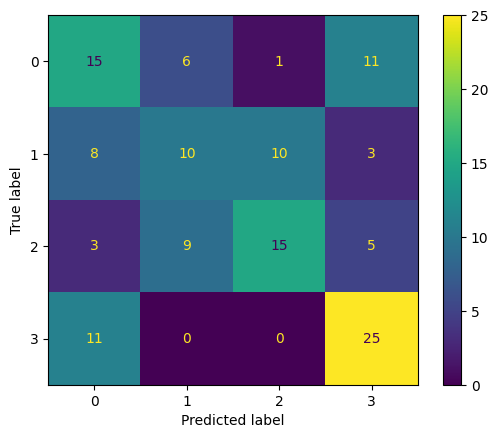

In [7]:
def naive_bayes_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    gnb = GaussianNB()
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    scores = []
#     confu_matrix = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
        
        gnb.fit(X_tr, y_tr)
#         y_pred = gnb.predict(X_te)
#         confu_matrix.append(y_pred)
        scores.append(gnb.score(X_te, y_te))
    
    result = np.mean(scores)
    print(f"{result:0.2f}")
    
    y_pred = gnb.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
naive_bayes_classifier()

C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.46


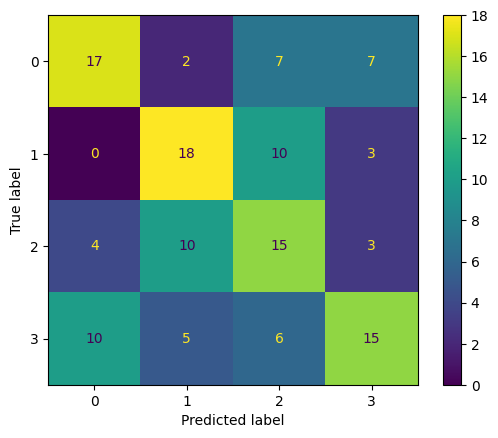

In [8]:
def neural_network_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10))
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    scores = []
    confu_matrix = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
    
        clf.fit(X_tr, y_tr)
#         y_pred = clf.predict(X_te)
        
#         confu_matrix.extend(y_pred)
        scores.append(clf.score(X_te, y_te))
        
    result = np.mean(scores)
    print(f"{result:0.2f}")
    
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
neural_network_classifier()

0.40


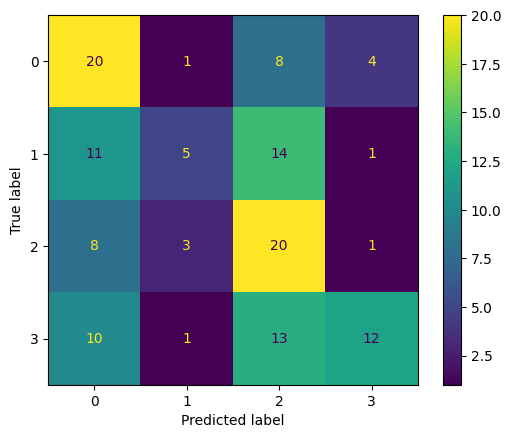

In [10]:
def ada_boost_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    ada = AdaBoostClassifier()
    skf = StratifiedKFold(n_splits=2, shuffle=True)
    
    scores = []
    confu_matrix = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
    
        ada.fit(X_tr, y_tr)
#         y_pred = ada.predict(X_te)
        
#         confu_matrix.extend(y_pred)
        scores.append(ada.score(X_te, y_te))
        
    result = np.mean(scores)
    print(f"{result:0.2f}")
    
    y_pred = ada.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
ada_boost_classifier()